In [ ]:
import pandas as pd
import numpy as np
import os
import openpyxl
from sklearn import preprocessing
from sklearn.preprocessing import MaxAbsScaler, OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit

In [ ]:
def TratamentoDadosLaboratorio (diretorio_pasta, dados_niumag, arquivo_laboratorio,
                                Pasta_Salvamento = None, Salvar = False, Data = None,
                                Fracoes_T2 = False, Dados_porosidade_Transverso = False):
    laboratorio = str(diretorio_pasta) + str(arquivo_laboratorio)
    dados_niumag = dados_niumag
    dados_lab = pd.read_excel(laboratorio)


    amostras = dados_niumag['Amostra']
    tempo_distribuicao = dados_niumag['Tempo Distribuicao']
    distribuicao_t2 = dados_niumag['Distribuicao T2']
    fitting_erro = dados_niumag['Fitting Error']
    fracao_argila = dados_niumag['Fracao Argila']
    porosidade_i = []
    poço = dados_niumag['Poço']
    media_ponderada_log = []
    s1 = []
    s2 = []
    s3 = []
    s4 = []

    codi_lab = preprocessing.LabelEncoder()
    categoria_lito = codi_lab.fit_transform(dados_lab['Litofacies'])
    onehot = OneHotEncoder()
    ohe = pd.DataFrame(onehot.fit_transform(dados_lab[['Litofacies']]).toarray())
    ohe.columns = onehot.categories_


    for i in np.arange(len(distribuicao_t2)):
        t2_transpose = pd.DataFrame([distribuicao_t2[i]]).T
        scaler = pd.DataFrame(MaxAbsScaler().fit_transform(t2_transpose))
        scaler_sum_phi = float(dados_lab['Porosidade RMN'][i])/float(scaler.sum())
        phi_i = []
        for j in np.arange(len(scaler)):
            p = float(scaler[0][j]*scaler_sum_phi)
            phi_i.append(p)
        porosidade_i.append(list(phi_i))

    for i in np.arange(len(porosidade_i)):
        phi_i = porosidade_i[i]
        tempo_log = np.log(tempo_distribuicao[i])
        produto_porosidade_t2_log = pd.DataFrame(phi_i*tempo_log)
        sum_num = np.sum(produto_porosidade_t2_log)
        sum_den = np.sum(phi_i)
        razao_t2 = float(np.exp(sum_num/sum_den))
        media_ponderada_log.append((razao_t2))

    dados = pd.DataFrame({'Amostra': amostras})
    dados['Poço'] = poço
    dados['Litofacies'] = dados_lab['Litofacies']
    dados['Categoria Litofacies'] = categoria_lito
    dados['Bioturbiditos'] = ohe['Bioturbated']
    dados['Dolowackstone'] = ohe['Dolowackstone']
    dados['Grainstone'] = ohe['Grainstone']
    dados['Brechado'] = ohe['Brechado']
    dados['Tempo Distribuicao'] = pd.Series(tempo_distribuicao)
    dados['Distribuicao T2'] = pd.Series(distribuicao_t2)
    dados['Porosidade i'] = pd.Series(porosidade_i)
    dados['Porosidade Gas'] = dados_lab['Porosidade Gas']/100
    dados['Porosidade RMN'] = dados_lab['Porosidade RMN']/100
    dados['Permeabilidade Gas'] = dados_lab['Permeabilidade Gas']
    dados['Fracao Argila'] =  fracao_argila
    dados['Fitting Error'] = fitting_erro
    dados['T2 Ponderado Log'] = media_ponderada_log


    if Fracoes_T2 == True:
        for i in np.arange(len(porosidade_i)):
            phi_i = pd.Series(porosidade_i[i])
            porosidade = np.sum(porosidade_i[i])
            a1 = phi_i[:74].sum()
            a2 = phi_i[74:84].sum()
            a3 = phi_i[84:92].sum()
            a4 = phi_i[92:].sum()
            phimicro = a1/porosidade
            phimeso  = a2/porosidade
            phimacro = a3/porosidade
            phisuper = a4/porosidade

            if phimicro <= 0.0001:
              phimicro = 0.0001
            if phimeso <= 0.0001:
              phimeso = 0.0001
            if phimacro <= 0.0001:
              phimacro = 0.0001
            if phisuper <= 0.0001:
              phisuper = 0.0001

            s1.append(phimicro)
            s2.append(phimeso)
            s3.append(phimacro)
            s4.append(phisuper)


        dados['S1'] = s1
        dados['S2'] = s2
        dados['S3'] = s3
        dados['S4'] = s4

    if Dados_porosidade_Transverso == True:
        dataframe_porosidade = dados['Porosidade i']
        array_tempo_distribuicao = dados['Tempo Distribuicao']
        array_amostras = dados ['Amostra']
        df = pd.DataFrame([[0 for col in range(len(array_tempo_distribuicao[0]))] for row in range(len(array_amostras))])
        colunas = []
        for i in range(len(array_amostras)):
            for j in np.arange(len(array_tempo_distribuicao[0])):
                por = dataframe_porosidade[i][j]
                string = 'T2 ' + str(array_tempo_distribuicao[i][j])
                colunas.append(string)
                df[j][i] = por
        df.columns = colunas[0:128]
        dados = pd.concat([dados, df], axis = 1)

    if Salvar == True:
        local_salvamento = Pasta_Salvamento + 'Dados_Gerais_' + Data + '.xlsx'
        dados.to_excel(local_salvamento, sheet_name='Dados')                          # Salvar dataframe

    return dados

In [ ]:
dados_niumag = pd.read_excel('/content/drive/MyDrive/Mestrado/Artigo - 1/Dados RMN/AA.xlsx').drop('File Name', axis=1)
df = dados_niumag.T.reset_index().drop('index', axis = 1).T
inicio = 15-2                                                   # Linha que se inicia os dados de da inversão
final = inicio+128
distribuicao = df[7+4][inicio:final]
tempo = df[7+3][inicio:final]
dados = pd.DataFrame({'Tempo Distribuição': tempo,
                      'Sinal': distribuicao}).reset_index().drop('index', axis = 1)
t2_transpose = pd.DataFrame([dados['Sinal']]).T
scaler = pd.DataFrame(MaxAbsScaler().fit_transform(t2_transpose))
dados['Escala'] = scaler
scaler_sum_phi = float(19.8)/float(scaler.sum())
phi = []
for j in np.arange(len(scaler)):
  p = float(scaler[0][j]*scaler_sum_phi)
  phi.append(p)

dados['Phi_i'] = phi

<ipython-input-4-d53349424b16>:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data = dados,


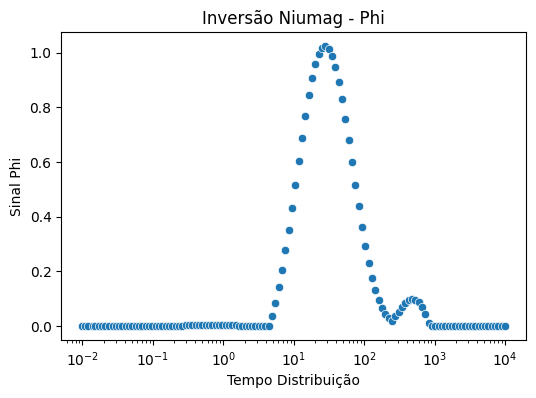

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.subplots(figsize = (6,4))
sns.scatterplot(data = dados,
                    x = 'Tempo Distribuição',
                    y = 'Phi_i',
                    palette = 'Spectral')

plt.title('Inversão Niumag - Phi')
plt.xlabel('Tempo Distribuição')
plt.ylabel('Sinal Phi')

plt.xscale('log')
plt.show()

In [ ]:
def TratamentoDadosNiumag (diretorio_pasta, arquivo_niumag, inicio_conversao, pontos_inversao,
                           Pasta_Salvamento = None, Salvar = False, Data = None, T2_niumag_gm = False,
                           T2_niumag_av = False):

    niumag = str(diretorio_pasta) + str(arquivo_niumag)                           # Pasta do arquivp
    dados_niumag = pd.read_excel(niumag).drop('File Name', axis=1)                # Dataframe dos Dados da Niumag

    inicio = inicio_conversao-2                                                   # Linha que se inicia os dados de da inversão
    final = inicio+pontos_inversao                                                # Linha final da Inversão

    amostras = []
    tempo_distribuicao = []
    distribuicao_t2 = []
    t2gm_niumag = []
    t2av_niumag = []
    fitting_erro = []
    fracao_argila = []
    poço = []

    for i in np.arange(int(len(dados_niumag.columns)/7)):
        df = dados_niumag.T.reset_index().drop('index', axis = 1).T
        nome = dados_niumag.columns[i*7][:9]
        tempo = df[i*7+3][inicio:final]
        distribuicao = df[i*7+4][inicio:final]
        gm = float(df[i*7+2][1][7:-4])
        av = float(df[i*7+2][2][7:-4])
        fit_erro = float(df[i*7][0][-5:])
        argila = sum(distribuicao[:53])/sum(distribuicao)
        p = nome[:4]
        amostras.append(nome)
        poço.append(p)
        tempo_distribuicao.append(list(tempo))
        distribuicao_t2.append(list(distribuicao))
        t2gm_niumag.append(gm)
        t2av_niumag.append(av)
        fitting_erro.append(fit_erro)
        fracao_argila.append(argila)

    dados = pd.DataFrame({'Amostra': amostras})
    dados['Poço'] = poço
    dados['Tempo Distribuicao'] = pd.Series(tempo_distribuicao)
    dados['Distribuicao T2'] = pd.Series(distribuicao_t2)
    dados['Fracao Argila'] =  fracao_argila
    dados['Fitting Error'] = fitting_erro

    if T2_niumag_gm == True:
        dados['T2 Geometrico Niumag'] = t2gm_niumag

    if T2_niumag_av == True:
        dados['T2 Medio Niumag'] = t2av_niumag

    if Salvar == True:
        local_salvamento = Pasta_Salvamento + 'Dados_Niumag_' + arquivo_niumag[:-5] + '_' + Data + '.xlsx'
        dados.to_excel(local_salvamento, sheet_name='Dados')                          # Salvar dataframe


    return dados



In [ ]:
# Diretório principal
diretório_pasta = '/content/drive/MyDrive/Mestrado/Artigo - 1/Dados RMN/'

# Arquivos Niumag
aa = 'AA.xlsx'
af = 'AF.xlsx'
at = 'AT.xlsx'

# Arquivo Laboratório
lab = 'Dados-Lab.xlsx'

# Salvamento
salvar = '/content/drive/MyDrive/Mestrado/Artigo - 1/Dados-Salvos/'

In [ ]:
dados_aa = TratamentoDadosNiumag(diretório_pasta, aa, 15, 128)
dados_at = TratamentoDadosNiumag(diretório_pasta, at, 15, 128)
dados_af = TratamentoDadosNiumag(diretório_pasta, af, 15, 128)
dados_niumag = pd.concat([dados_aa, dados_af, dados_at]).reset_index().drop('index', axis = 1)
dados = TratamentoDadosLaboratorio(diretório_pasta, dados_niumag, lab, salvar, Salvar=True, Data= '28-10',
                                   Fracoes_T2=True, Dados_porosidade_Transverso=True)

<ipython-input-2-939bbe5a31e4>:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[j][i] = por


In [ ]:
sss = StratifiedShuffleSplit(n_splits=2, train_size=.7, random_state=42)

X = dados.drop('Categoria Litofacies', axis = 1)
groups = dados['Categoria Litofacies']

for i, (train_index, test_index) in enumerate(sss.split(X, groups)):
  print(f"Fold {i}:")

Fold 0:
Fold 1:


In [ ]:
dados_treino = dados.iloc[train_index]
dados_teste = dados.iloc[test_index]

salvar_treino = salvar + 'Dados_treino_28_10.xlsx'
salvar_teste = salvar + 'Dados_teste_28_10.xlsx'

dados_treino.to_excel(salvar_treino)
dados_teste.to_excel(salvar_teste)